# Symbolic Regression with back-prop

Lets first import dcgpy and pyaudi and set up things as to use dCGP on gduals defined over vectorized floats

In [277]:
from dcgpy import expression_gdual_vdouble as expression
from dcgpy import kernel_set_gdual_vdouble as kernel_set
from pyaudi import gdual_vdouble as gdual
import pyaudi
from matplotlib import pyplot as plt
import numpy as np
from numpy import sin, cos
from random import randint
np.seterr(all='ignore') # avoids numpy complaining about early on malformed expressions being evalkuated
%matplotlib inline

## 1 - We define the set of kernel functions we will be using

In [782]:
kernels = kernel_set(["sum", "mul", "diff","pdiv"])() # note the call operator (returns the list of kernels)

## 2 - We instantiate a (1 in 1 out) dCGP and we inspect a randomly created program

0.0 0.0 0.0 [1]
0.0 2.0 0.0 [c**2 + c]
-0.25 2.0 -0.25 [4*c**4/x]


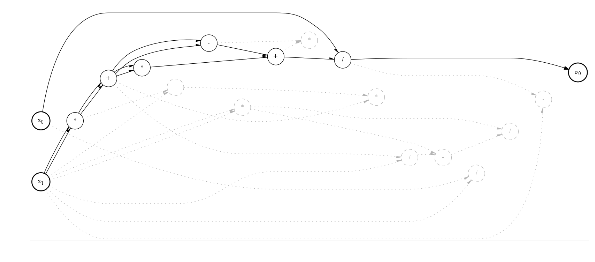

Represented expression:  (((((c*c)+(c*c))*((c*c)+(c*c)))+(((c*c)+(c*c))-((c*c)+(c*c))))/x)
Simplified expression:  [4*c**4/x]


In [783]:
dCGP = expression(inputs=2, outputs=1, rows=1, cols=15, levels_back=16, arity=2, kernels=kernels, seed = randint(0,1565646353))
cumsum=0
while(cumsum**2 < 1e-5):
    dCGP.mutate_active(10)
    term1 = dCGP([gdual([1],"x",1),gdual([0.5],"c",1)])[0].get_derivative({"dx" : 1})[0]
    term2 = dCGP([gdual([1],"x",1),gdual([0.5],"c",1)])[0].get_derivative({"dc" : 1})[0]
    cumsum=min(term1,term2)
    print(term1, term2, cumsum, dCGP.simplify(["x","c"]))

plt.rcParams["figure.figsize"] = [10,6]
dCGP.visualize() #requires pygraphwiz module installed
print("Represented expression: ", dCGP(["x","c"])[0])
print("Simplified expression: ", dCGP.simplify(["x","c"])) #requires sympy module installed

In [789]:
def target(x):
    return x**5 - np.pi*x**3 + x
x = np.linspace(1,3,10)
yt = target(x)
x = gdual(x)

In [790]:
def err(dCGP, yt, cin):
    c = gdual([cin], "c", 2)
    y = dCGP([x,c])[0]
    return (y-gdual(yt))**2

def err2(dCGP, yt,cin):
    c = gdual([cin], "c", 2)
    y = dCGP([x,c])[0]
    a = sum(err(dCGP,yt,cin).get_derivative({"dc":1}))
    b = sum(err(dCGP,yt,cin).get_derivative({"dc":2}))
    if b != 0:
        c = c - a/b
        y = dCGP([x,c])[0]
    return (y-gdual(yt))**2, c.constant_cf[0]

In [795]:
offsprings = 4
max_gen=10000
constant = 1.
chromosome = [1] * offsprings
fitness = [1] *offsprings
cout_off = [1]*offsprings
best_chromosome = dCGP.get()
fit, cout = err2(dCGP,yt,constant)
best_fitness = sum(fit.constant_cf)
for g in range(max_gen):
    for i in range(offsprings):
        dCGP.set(best_chromosome)
        cumsum=0
        dCGP.mutate_active(i)
        fit, cout = err2(dCGP,yt,constant)
        fitness[i] = sum(fit.constant_cf )
        chromosome[i] = dCGP.get()
        cout_off[i] = cout
    for i in range(offsprings):
        if fitness[i] <= best_fitness:
            if (fitness[i] != best_fitness):
                best_chromosome = chromosome[i]
                best_fitness = fitness[i]
                dCGP.set(best_chromosome)
                print("New best found: gen: ", g, " value: ", fitness[i],  dCGP.simplify(["x","c"]), cout_off[i])

    if best_fitness < 1e-7:
        break

New best found: gen:  0  value:  40876.840011371474 [0] 1.0
New best found: gen:  0  value:  17424.397612076027 [c - c/x - x + 1] 102.95841123448392
New best found: gen:  4  value:  12254.81824388169 [-c*x + c/x] -32.16512667680763
New best found: gen:  7  value:  10409.25008379886 [-c*x + c] -46.52743752048102
New best found: gen:  24  value:  5906.689279249751 [c*x**2 - c*x + x**2] 17.540725169046645
New best found: gen:  31  value:  5630.2120363122085 [c*x**2 - c*x + x**2 - x] 18.17017081064927
New best found: gen:  32  value:  5365.883208499688 [c*x**2 - c*x - x] 19.799616452251897
New best found: gen:  35  value:  3398.338365836664 [c*x**2 - c*x - c] 25.47235677921828
New best found: gen:  254  value:  2980.4682009395137 [c**2*x**2 + c*x**4] 1.4591726110276644
New best found: gen:  255  value:  2167.1740911105044 [-c**2*x**2 + c*x**4] 1.8600591037838767
New best found: gen:  257  value:  2035.951987142738 [c*x**4] 1.6996925841793735
New best found: gen:  268  value:  1184.73596238

In [770]:
dCGP.simplify(["x","c"])

[c/x]

In [716]:
c = -0.08028767454880459
e =  sum(err(dCGP,yt,c).constant_cf)
a = sum(err(dCGP,yt,c).get_derivative({"dc":1}))
b = sum(err(dCGP,yt,c).get_derivative({"dc":2}))
print("error: ", e)
print("dedt: ", a)
print("d2edt2: ", b)

error:  29642.170049026627
dedt:  14597.362277395943
d2edt2:  3594.2541505077697


In [719]:
c = -0.08028767454880459
e =  sum(err2(dCGP,yt,c)[0].constant_cf)
a = sum(err2(dCGP,yt,c)[0].get_derivative({"dc":1}))
b = sum(err2(dCGP,yt,c)[0].get_derivative({"dc":2}))
print("error: ", e)
print("dedt: ", a)
print("d2edt2: ", b)
err2(dCGP,yt,c)

error:  3.8161146290066446e-29
dedt:  -8.668572642203552e-14
d2edt2:  3594.2541505077697


([0, 4.93038e-32, 2.41589e-30, 1.59744e-29, 1.97215e-29, ... ]+[0, 8.10813e-16, 9.36852e-15, -3.70074e-14, -5.98576e-14, ... ]*dc+[1, 3.3335, 9.08249, 21.4335, 45.4191, ... ]*dc**2,
 -4.141592653589793)

In [715]:
c

-0.08028767454880459